In [22]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
from scipy import signal as sc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score
from math import floor, ceil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import os
from math import floor, ceil
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import colors
import seaborn as sns
from adabelief_pytorch import AdaBelief
from termcolor import colored


In [23]:
class CustomImageDataset(Dataset):
  def __init__(self, labels_file, img_dir, projection=None, transform=None):
    self.img_labels = scipy.io.loadmat(labels_file)['code_bdh'][0]
    self.img_dir = img_dir
    self.transform = transform
    self.imgs = [img for img in os.listdir(img_dir)]
    self.imgs.sort() 
    self.projection = projection

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = Image.open(self.img_dir + '/' + self.imgs[idx])
    label = self.img_labels[idx] -1
    if self.transform:
      image = self.transform(image)
    if self.projection:
      image = torch.sum(image, axis=1).unsqueeze(1)
    return image, label

In [37]:
transform = T.Compose([
   T.Resize((200, 600)),
   T.ToTensor()
]) 
img_dir = 'data_2021/data_2021/png'
labels_file = 'data_2021/data_2021/code_bdh.mat'

In [38]:
dataset = CustomImageDataset(labels_file, img_dir, transform=transform, projection=True) 
train_set, test_set = torch.utils.data.random_split(dataset, [floor(len(dataset) * 0.85), ceil(len(dataset)*0.15)])
train_loader = DataLoader(train_set, batch_size=1028 , shuffle=True)
test_loader = DataLoader(test_set, batch_size=1028, shuffle=True)

In [39]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([1028, 3, 1, 600])


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [41]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

11187798

In [43]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [44]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


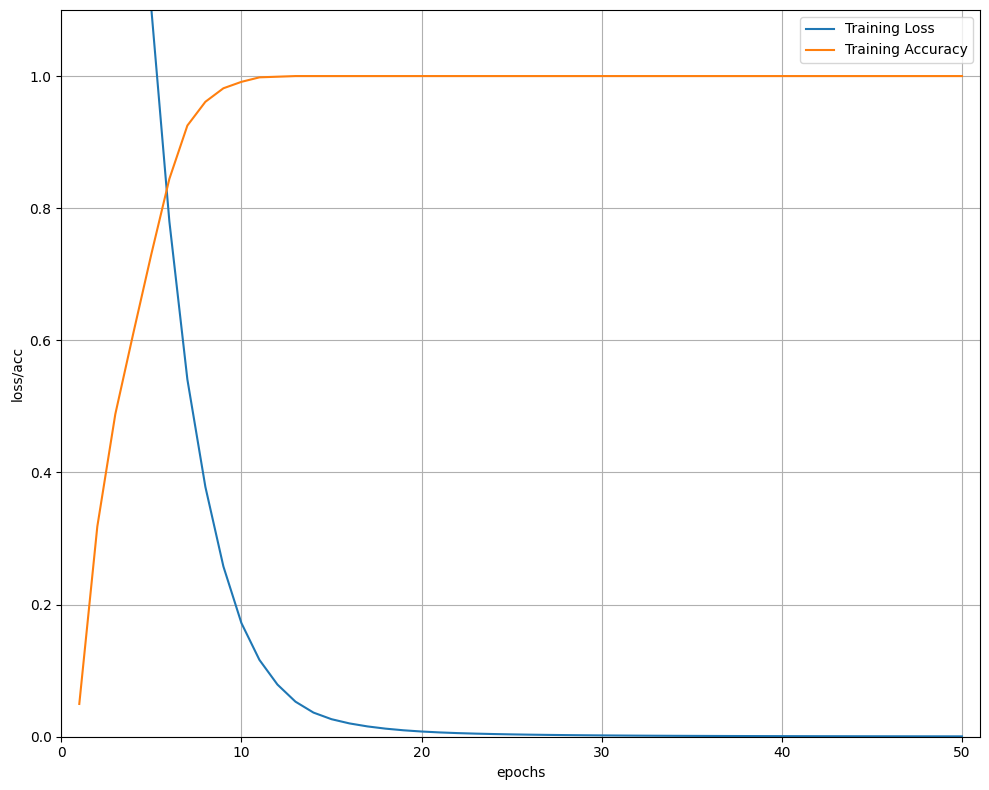

In [45]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [47]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:42<?, ?it/s,  Val Loss:=0.344,  Val Acc:=0.888,  
  2%|▏         | 1/50 [00:42<34:43, 42.51s/it,  Val Loss:=0.344,  Val Acc:=0.888,  
  2%|▏         | 1/50 [01:08<34:43, 42.51s/it,  Val Loss:=0.267,  Val Acc:=0.921,  
  4%|▍         | 2/50 [01:08<26:16, 32.84s/it,  Val Loss:=0.267,  Val Acc:=0.921,  
  4%|▍         | 2/50 [01:33<26:16, 32.84s/it,  Val Loss:=0.199,  Val Acc:=0.949,  
  6%|▌         | 3/50 [01:33<23:01, 29.40s/it,  Val Loss:=0.199,  Val Acc:=0.949,  
  6%|▌         | 3/50 [01:59<23:01, 29.40s/it,  Val Loss:=0.14,  Val Acc:=0.952,  
  8%|▊         | 4/50 [01:59<21:15, 27.74s/it,  Val Loss:=0.14,  Val Acc:=0.952,  
  8%|▊         | 4/50 [02:23<21:15, 27.74s/it,  Val Loss:=0.15,  Val Acc:=0.962,  
 10%|█         | 5/50 [02:23<19:59, 26.66s/it,  Val Loss:=0.15,  Val Acc:=0.962,  
 10%|█         | 5/50 [02:48<19:59, 26.66s/it,  Val Loss:=0.179,  Val Acc:=0.959,  
 12%|█▏        | 6/50 [02:48<19:02, 25.96s/it,  Val Loss:=0.179,  Val Acc:=0.959,  
 12%

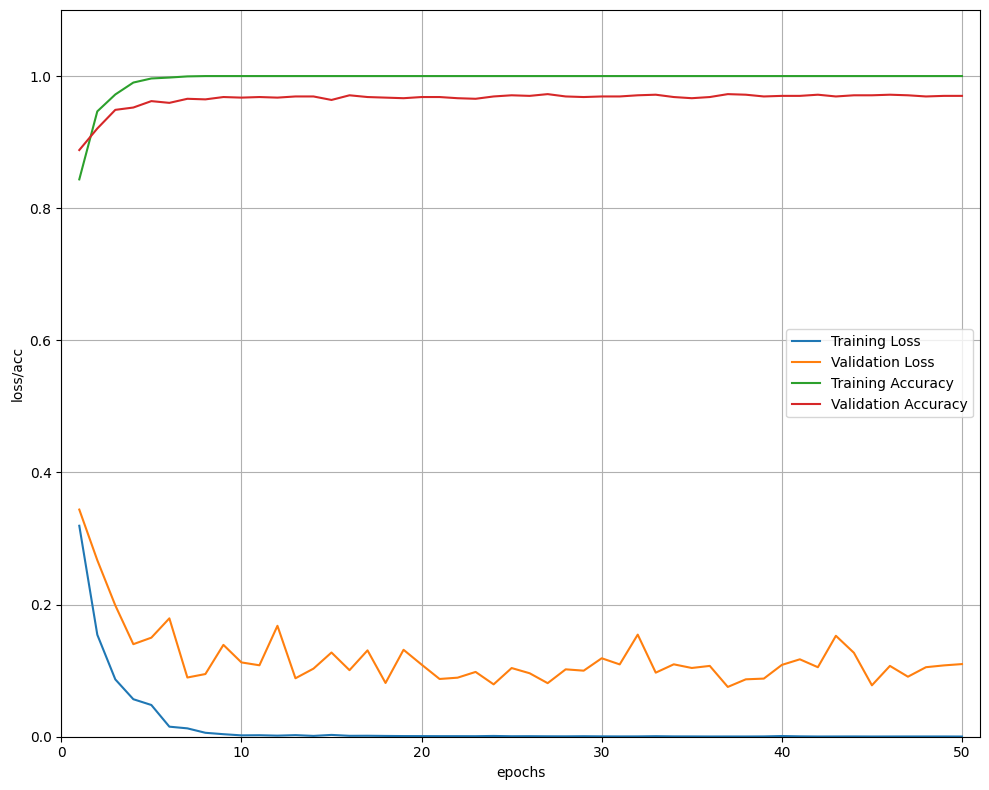

In [48]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


<AxesSubplot: >

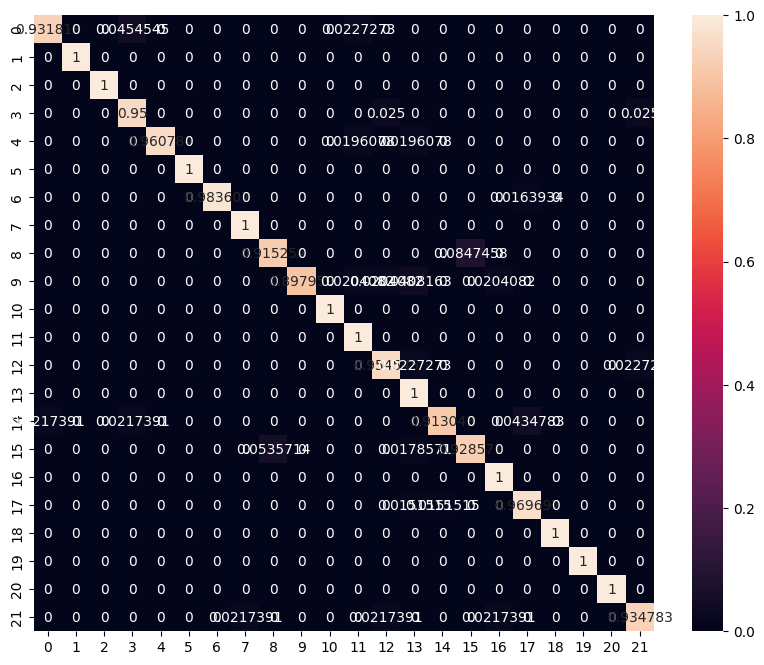

In [50]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [51]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     0.9762    0.9318    0.9535        44
           1     1.0000    1.0000    1.0000        64
           2     1.0000    1.0000    1.0000        60
           3     0.9268    0.9500    0.9383        40
           4     1.0000    0.9608    0.9800        51
           5     1.0000    1.0000    1.0000        38
           6     1.0000    0.9836    0.9917        61
           7     0.9773    1.0000    0.9885        43
           8     0.9474    0.9153    0.9310        59
           9     1.0000    0.8980    0.9462        49
          10     1.0000    1.0000    1.0000        63
          11     0.9444    1.0000    0.9714        51
          12     0.9333    0.9545    0.9438        44
          13     0.8846    1.0000    0.9388        46
          14     0.9767    0.9130    0.9438        46
          15     0.9123    0.9286    0.9204        56
          16     0.9636    1.0000    0.9815        53
          17     0.9552    

In [52]:
from efficientnet_pytorch import EfficientNet
torchvision.models.efficientnet_v2_l

<function torchvision.models.efficientnet.efficientnet_v2_l(*, weights: Optional[torchvision.models.efficientnet.EfficientNet_V2_L_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.efficientnet.EfficientNet>

In [53]:
from torch.nn.parallel import DistributedDataParallel as DDP


In [54]:
model = model = torchvision.models.efficientnet_b0(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

5299834

In [56]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [57]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


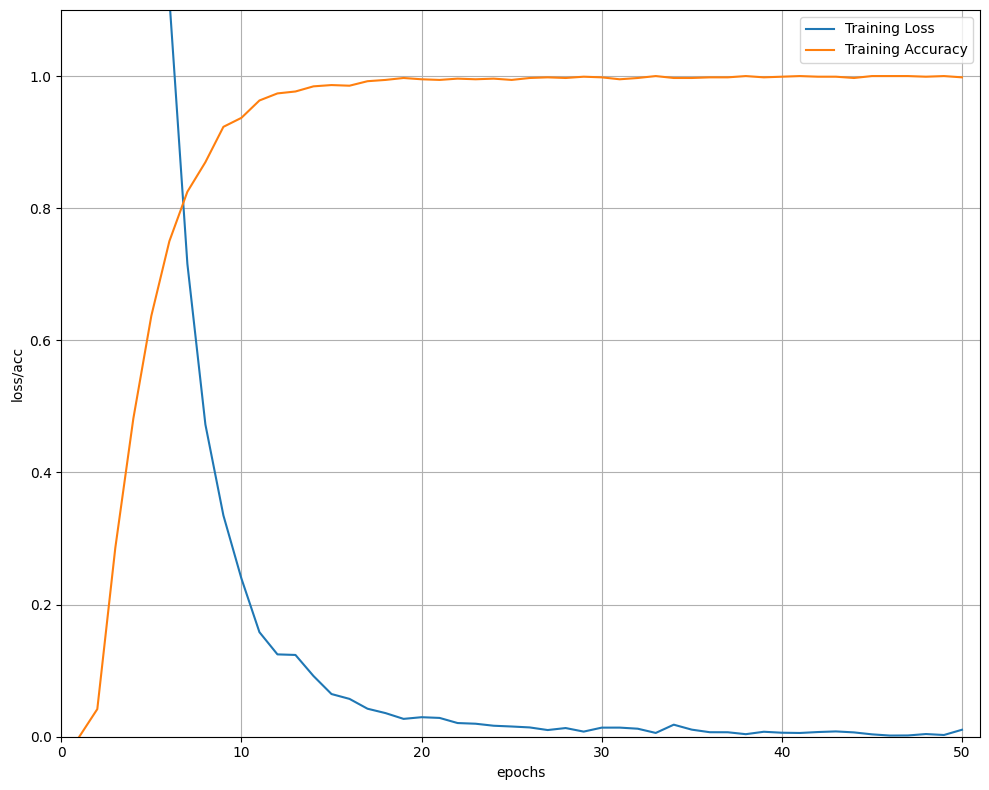

In [58]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [60]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:20<?, ?it/s,  Val Loss:=0.428,  Val Acc:=0.865,  
  2%|▏         | 1/50 [00:20<17:07, 20.97s/it,  Val Loss:=0.428,  Val Acc:=0.865,  
  2%|▏         | 1/50 [00:41<17:07, 20.97s/it,  Val Loss:=0.339,  Val Acc:=0.913,  
  4%|▍         | 2/50 [00:41<16:40, 20.85s/it,  Val Loss:=0.339,  Val Acc:=0.913,  
  4%|▍         | 2/50 [01:03<16:40, 20.85s/it,  Val Loss:=0.201,  Val Acc:=0.927,  
  6%|▌         | 3/50 [01:03<16:30, 21.07s/it,  Val Loss:=0.201,  Val Acc:=0.927,  
  6%|▌         | 3/50 [01:24<16:30, 21.07s/it,  Val Loss:=0.26,  Val Acc:=0.936,  
  8%|▊         | 4/50 [01:24<16:07, 21.04s/it,  Val Loss:=0.26,  Val Acc:=0.936,  
  8%|▊         | 4/50 [01:44<16:07, 21.04s/it,  Val Loss:=0.262,  Val Acc:=0.937,  
 10%|█         | 5/50 [01:44<15:44, 21.00s/it,  Val Loss:=0.262,  Val Acc:=0.937,  
 10%|█         | 5/50 [02:06<15:44, 21.00s/it,  Val Loss:=0.162,  Val Acc:=0.94,  
 12%|█▏        | 6/50 [02:06<15:27, 21.07s/it,  Val Loss:=0.162,  Val Acc:=0.94,  
 12%

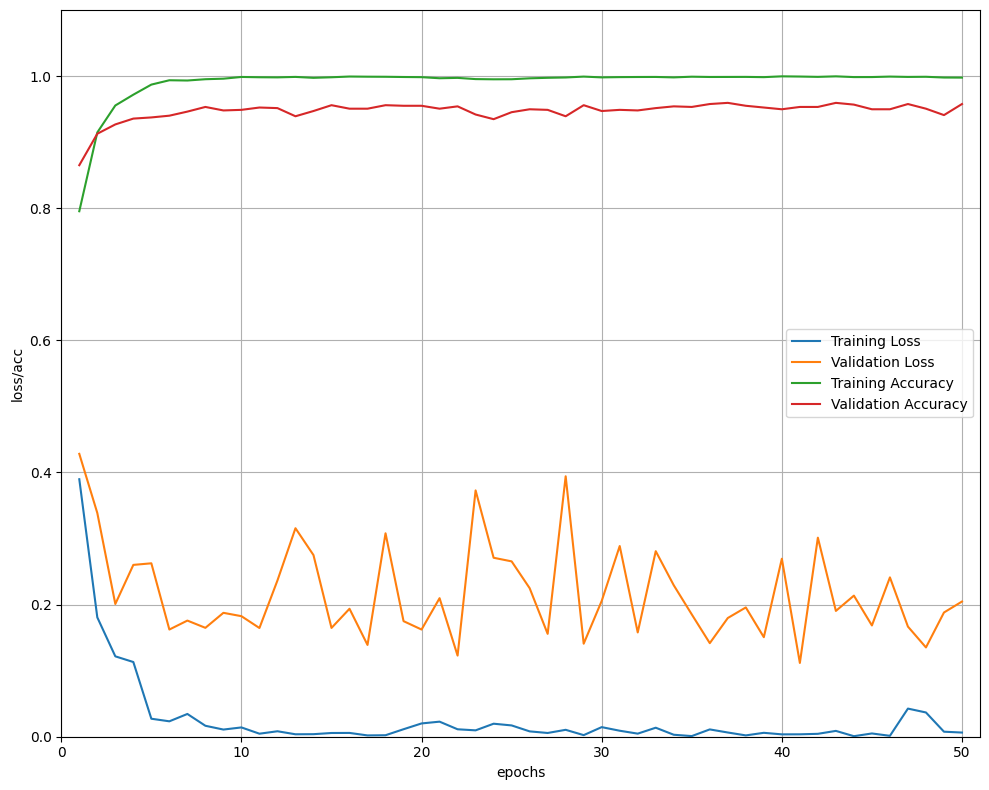

In [61]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


<AxesSubplot: >

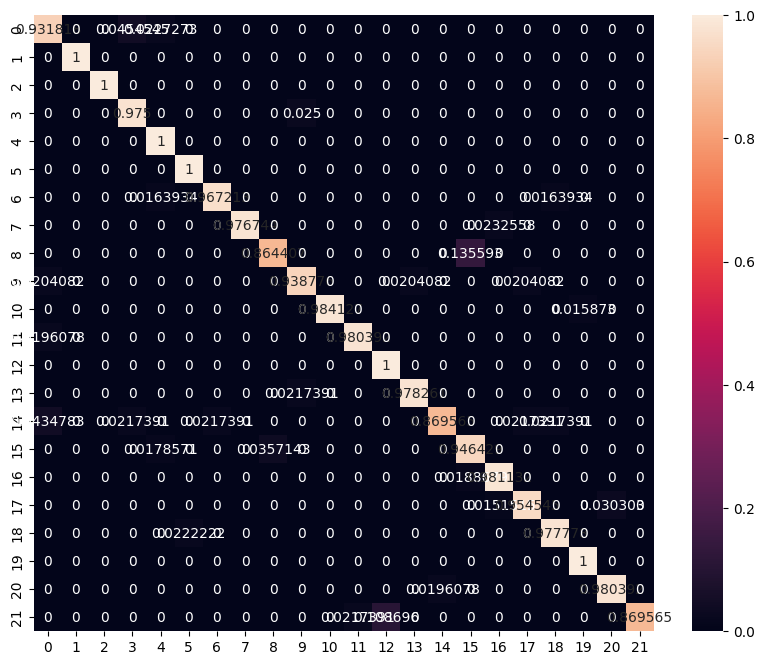

In [63]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [64]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     0.9111    0.9318    0.9213        44
           1     1.0000    1.0000    1.0000        64
           2     1.0000    1.0000    1.0000        60
           3     0.9286    0.9750    0.9512        40
           4     0.9444    1.0000    0.9714        51
           5     0.9744    1.0000    0.9870        38
           6     0.9833    0.9672    0.9752        61
           7     1.0000    0.9767    0.9882        43
           8     0.9623    0.8644    0.9107        59
           9     0.9583    0.9388    0.9485        49
          10     1.0000    0.9841    0.9920        63
          11     0.9804    0.9804    0.9804        51
          12     0.8980    1.0000    0.9462        44
          13     0.9783    0.9783    0.9783        46
          14     0.9756    0.8696    0.9195        46
          15     0.8548    0.9464    0.8983        56
          16     0.9630    0.9811    0.9720        53
          17     0.9692    

In [65]:
import torchvision.transforms as transforms


In [66]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_small_patch16_224', pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

Using cache found in /home/benx13/.cache/torch/hub/facebookresearch_deit_main


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

22061950

In [68]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [69]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=500, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/500 [00:00<?, ?it/s]


AssertionError: Caught AssertionError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/benx13/.local/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/benx13/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/benx13/.local/lib/python3.10/site-packages/timm/models/vision_transformer.py", line 549, in forward
    x = self.forward_features(x)
  File "/home/benx13/.local/lib/python3.10/site-packages/timm/models/vision_transformer.py", line 532, in forward_features
    x = self.patch_embed(x)
  File "/home/benx13/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/benx13/.local/lib/python3.10/site-packages/timm/models/layers/patch_embed.py", line 42, in forward
    _assert(H == self.img_size[0], f"Input image height ({H}) doesn't match model ({self.img_size[0]}).")
  File "/home/benx13/.local/lib/python3.10/site-packages/torch/__init__.py", line 827, in _assert
    assert condition, message
AssertionError: Input image height (1) doesn't match model (224).


In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
#plt.ylim(0, 1.1) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [ ]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

In [ ]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [ ]:
print(classification_report(y_test_list, y_pred_list, digits=4))


In [ ]:
def resunmetrain(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64,
    train_loss = [],
    train_acc = [],
    val_loss = [],
    val_acc = [],
    conf_mats = []):
    total_step = len(train_loader)
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [ ]:
modelbackup = model

In [ ]:
t_h, model = resunmetrain(model=model, criterion=criterion, optimizer=adam_belief, epochs=10, train_loader=train_loader, test_loader=test_loader,
    train_loss = t_h['train_loss'],
    train_acc = t_h['train_acc'],
    val_loss = t_h['val_loss'],
    val_acc = t_h['val_acc'],
    conf_mats = t_h['confusion_matrix'])

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

In [ ]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [ ]:
print(classification_report(y_test_list, y_pred_list, digits=4))
